In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import torchvision.transforms.functional as TF

In [2]:
from torch import optim
from torch.utils.data import DataLoader
from data.datasets.golden_panels import GoldenPanelsDataset
from networks.ssupervae_contextual_attentional import SSuperVAEContextualAttentional
from training.ssupervae_contextual_attn_trainer import SSuperVAEContextualAttentionalTrainer
from utils.config_utils import read_config, Config
from utils.plot_utils import *
from utils.logging_utils import *
from utils.image_utils import *
from configs.base_config import *
from functional.losses.elbo import elbo

In [3]:
config = read_config(Config.VAE_CONTEXT_ATTN)
golden_age_config = read_config(Config.GOLDEN_AGE)
ptu.set_gpu_mode(True)

In [5]:
panel_dim = golden_age_config.panel_dim[0]

In [6]:
net = SSuperVAEContextualAttentional(config.backbone,
                                         panel_img_size=panel_dim,
                                         latent_dim=config.latent_dim,
                                         embed_dim=config.embed_dim,
                                         seq_size=config.seq_size,
                                         decoder_channels=config.decoder_channels,
                                         gen_img_size=config.image_dim).to(ptu.device)

 

load_path = "/scratch/users/gsoykan20/projects/AF-GAN/playground/ssupervae/checkpoints/25-05-2021-00-01-41_model-checkpoint-epoch51.pth"
net.load_state_dict(torch.load(load_path)['model_state_dict'])
net = net.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [14]:
data = GoldenPanelsDataset(golden_age_config.panel_path,
                           golden_age_config.sequence_path,
                           golden_age_config.panel_dim,
                           config.image_dim,
                           augment=False,
                           mask_val=golden_age_config.mask_val,
                           mask_all=golden_age_config.mask_all,
                           return_mask=golden_age_config.return_mask,
                           train_test_ratio=golden_age_config.train_test_ratio,
                           train_mode=False,
                           limit_size=-1)
data_loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=4)

In [15]:
dl_iter = iter(data_loader)

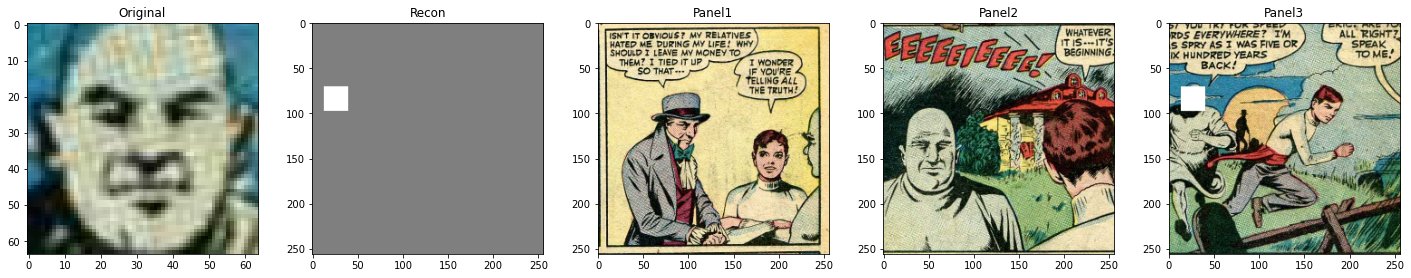

In [16]:
x, y, z, mask_coordinates = next(dl_iter)
plot_panels_and_faces(x, y, z.unsqueeze(0).repeat(1, 3, 1, 1))

In [36]:
## TEMP

In [24]:
stds = torch.Tensor([0.229, 0.224, 0.225])
means = torch.Tensor([0.485, 0.456, 0.406])

In [25]:
def convert_to_new_augmentation(img):
    img = img * stds.view(1, 3, 1, 1).cuda() + means.view(1, 3, 1, 1).cuda()
    img *= 2
    img -= 1
    return img

In [26]:
def convert_to_old_augmentation(img):
    img = (img + 1) / 2
    img = TF.normalize(img, mean=means, std=stds)
    return img

[INFO] Coarse Example: 0


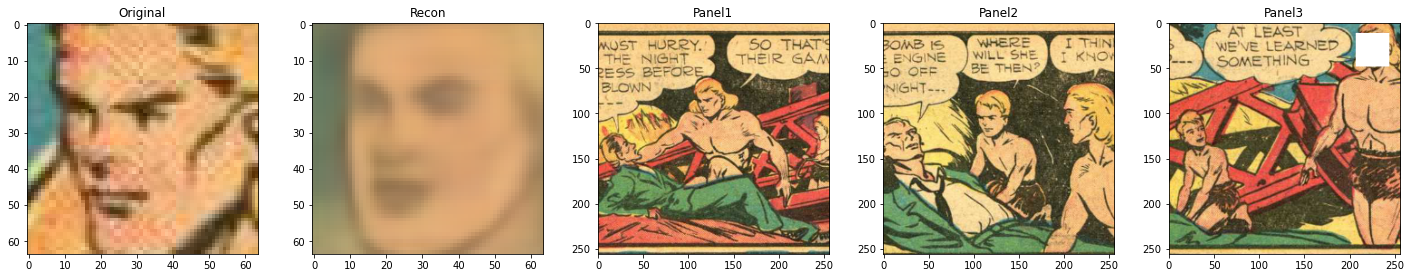

[INFO] Fine Example: 0


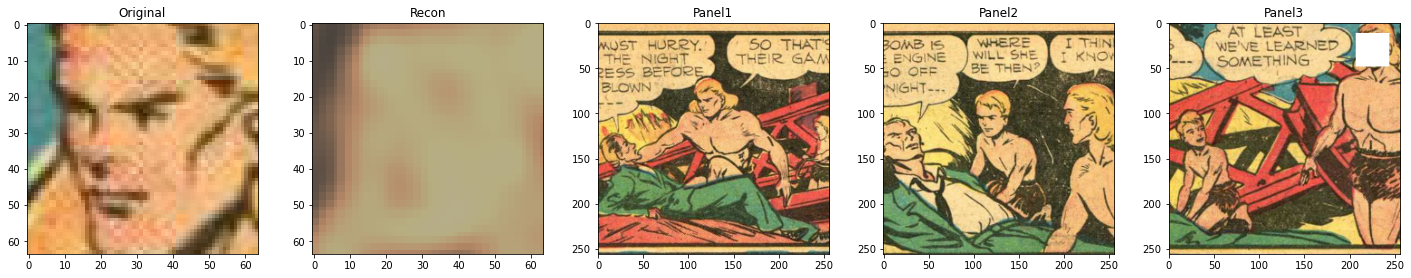

[INFO] Coarse Example: 1


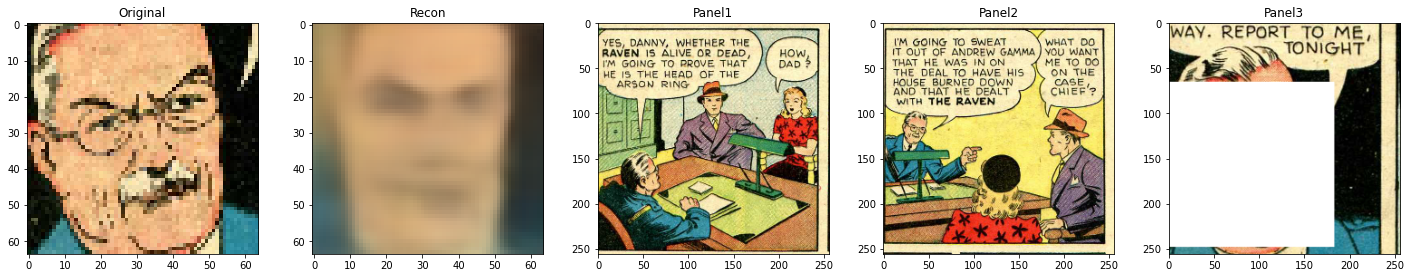

[INFO] Fine Example: 1


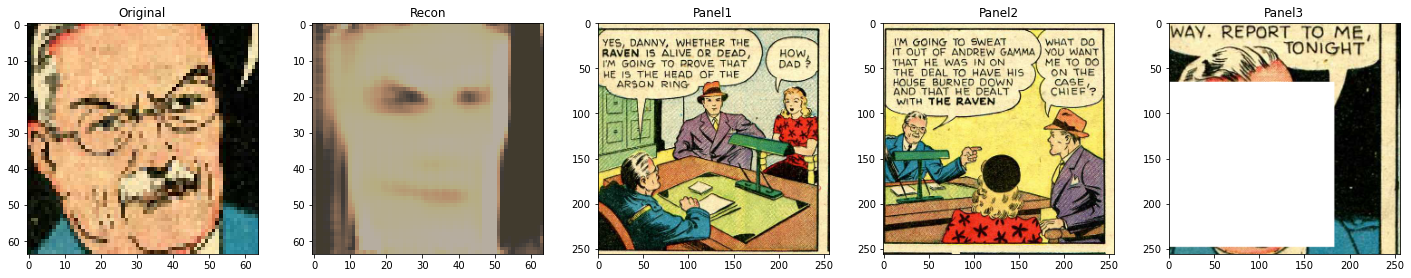

[INFO] Coarse Example: 2


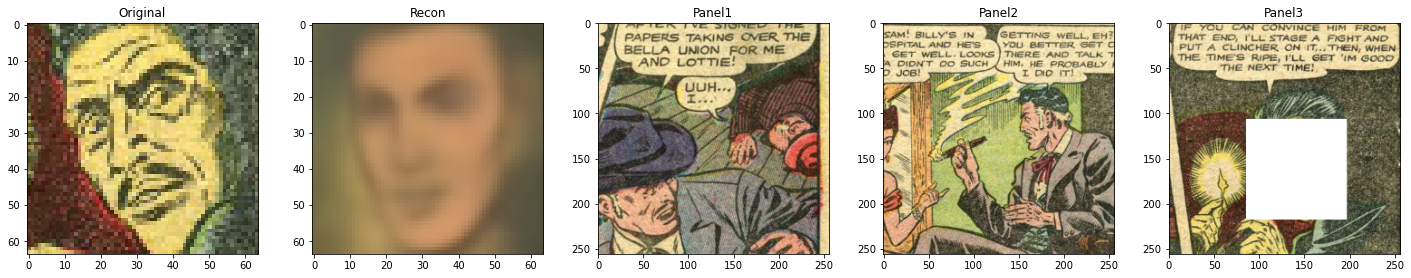

[INFO] Fine Example: 2


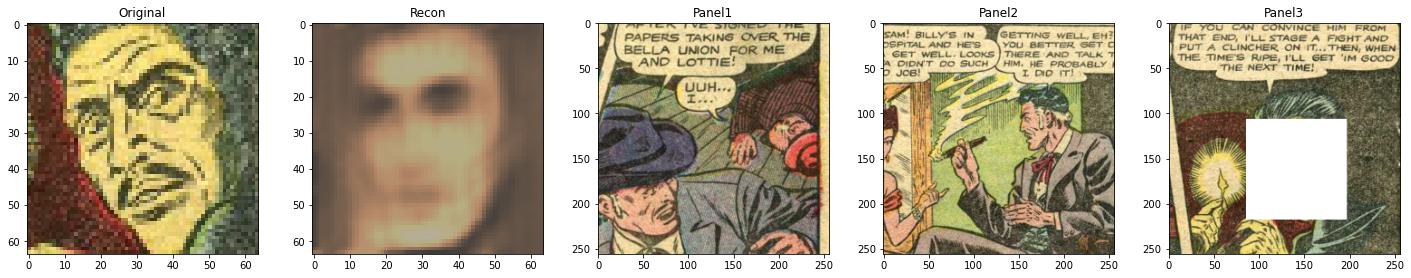

In [31]:
ctr, limit = 0, 3


for i in range(limit):
    x, y, mask, mask_coordinates = next(dl_iter)
    x_plain = convert_to_old_augmentation(x)
    _, _, interim_face_size, _ = y.shape
    with torch.no_grad():
        z, _, mu_z, mu_x, logstd_z = net(x_plain.cuda()) 
        _, _, x_stage_2, \
            offset_flow, \
            fine_faces, last_panel_gts = net.fine_generation_forward(x_plain.cuda(),
                                                            y.cuda(),
                                                            mask.cuda(),
                                                            mu_x.cuda(),
                                                            mask_coordinates,
                                                            interim_face_size=interim_face_size)
    print("[INFO] Coarse Example:", i)
    plot_panels_and_faces(x, y, convert_to_new_augmentation(mu_x).cpu())
    
    print("[INFO] Fine Example:", i)
    plot_panels_and_faces(x, y, convert_to_new_augmentation(fine_faces).cpu())


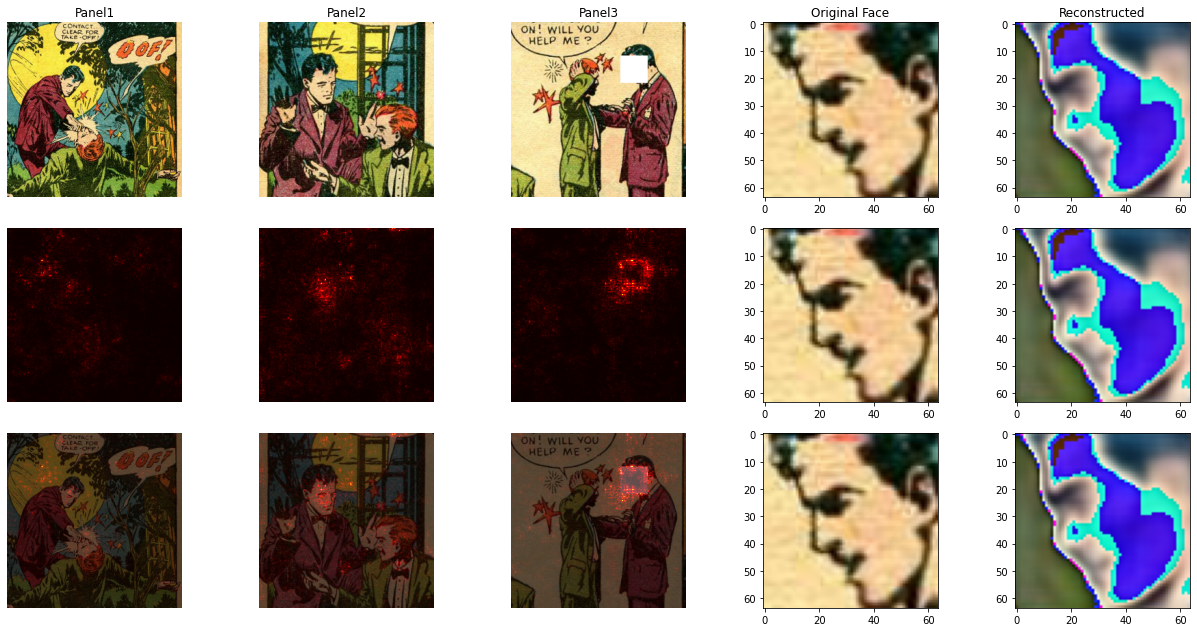

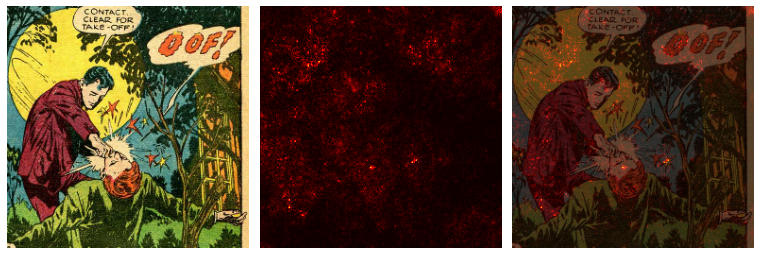

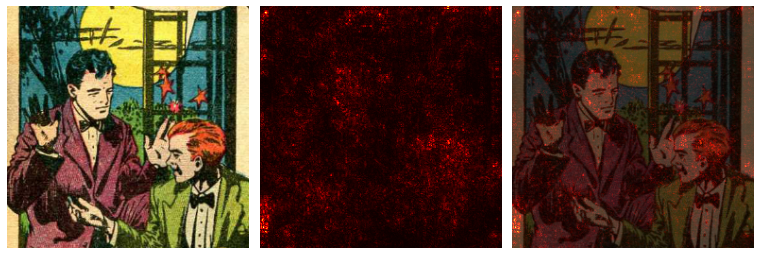

In [34]:
import copy

x, y, z, mask_coordinates = next(dl_iter)

draw_saliency(net, copy.deepcopy(x), copy.deepcopy(y))

draw_backbone_saliency(net.encoder.embedder, copy.deepcopy(x), 0)

draw_backbone_saliency(net.encoder.embedder, copy.deepcopy(x), 1)